In [1]:
import fsspec

fs = fsspec.filesystem('gs')
fs.ls('gs://gcp-public-data-arco-era5/co/')

['gcp-public-data-arco-era5/co/model-level-moisture.zarr',
 'gcp-public-data-arco-era5/co/model-level-moisture.zarr-v2',
 'gcp-public-data-arco-era5/co/model-level-wind.zarr',
 'gcp-public-data-arco-era5/co/model-level-wind.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-forecast.zarr',
 'gcp-public-data-arco-era5/co/single-level-forecast.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-reanalysis.zarr',
 'gcp-public-data-arco-era5/co/single-level-reanalysis.zarr-v2',
 'gcp-public-data-arco-era5/co/single-level-surface.zarr',
 'gcp-public-data-arco-era5/co/single-level-surface.zarr-v2']

In [2]:
import xarray

ds = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={'time': 48},
    storage_options=dict(token='anon'),
)["2m_temperature"].sel(time=slice('1990-01-01', '2024-11-01'))

ds_for = xarray.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks={'time': 48},
    storage_options=dict(token='anon'),
)["maximum_2m_temperature_since_previous_post_processing"].sel(time=slice('1990-01-01', '2024-11-01'))

print(ds_for)

<xarray.DataArray 'maximum_2m_temperature_since_previous_post_processing' (
                                                                           time: 305376,
                                                                           latitude: 721,
                                                                           longitude: 1440)>
dask.array<getitem, shape=(305376, 721, 1440), dtype=float32, chunksize=(48, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1990-01-01 ... 2024-11-01T23:00:00
Attributes:
    long_name:   Maximum temperature at 2 metres since previous post-processing
    short_name:  mx2t
    units:       K


In [3]:
def lon_to_360(dlon: float) -> float:
  return ((360 + (dlon % 360)) % 360)

champaign_coords = {"min_lat": 40.07651334790849, "max_lat": 40.3265133, "min_long": lon_to_360(-88.38088352464067), "max_long": lon_to_360(-88.0608835)}

champaign_ds = ds.where(
    (ds.longitude > champaign_coords["min_long"]) & (ds.latitude > champaign_coords["min_lat"]) &
    (ds.longitude < champaign_coords["max_long"]) & (ds.latitude < champaign_coords["max_lat"]),
    drop=True
)

champaign_spatially_expanded_ds = ds.where (
    (ds.longitude > champaign_coords["min_long"] - 0.25) & (ds.latitude > champaign_coords["min_lat"] - 0.25) &
    (ds.longitude < champaign_coords["max_long"] + 0.25) & (ds.latitude < champaign_coords["max_lat"] + 0.25),
    drop=True
)

champaign_ds_for = ds_for.where(
    (ds_for.longitude > champaign_coords["min_long"]) & (ds_for.latitude > champaign_coords["min_lat"]) &
    (ds_for.longitude < champaign_coords["max_long"]) & (ds_for.latitude < champaign_coords["max_lat"]),
    drop=True
)

champaign_spatially_expanded_ds_for = ds_for.where (
    (ds_for.longitude > champaign_coords["min_long"] - 0.25) & (ds_for.latitude > champaign_coords["min_lat"] - 0.25) &
    (ds_for.longitude < champaign_coords["max_long"] + 0.25) & (ds_for.latitude < champaign_coords["max_lat"] + 0.25),
    drop=True
)

champaign_ds_for

<xarray.DataArray 'maximum_2m_temperature_since_previous_post_processing' (
                                                                           time: 305376,
                                                                           latitude: 1,
                                                                           longitude: 1)>
dask.array<where, shape=(305376, 1, 1), dtype=float32, chunksize=(48, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 40.25
  * longitude  (longitude) float32 271.8
  * time       (time) datetime64[ns] 1990-01-01 ... 2024-11-01T23:00:00
Attributes:
    long_name:   Maximum temperature at 2 metres since previous post-processing
    short_name:  mx2t
    units:       K

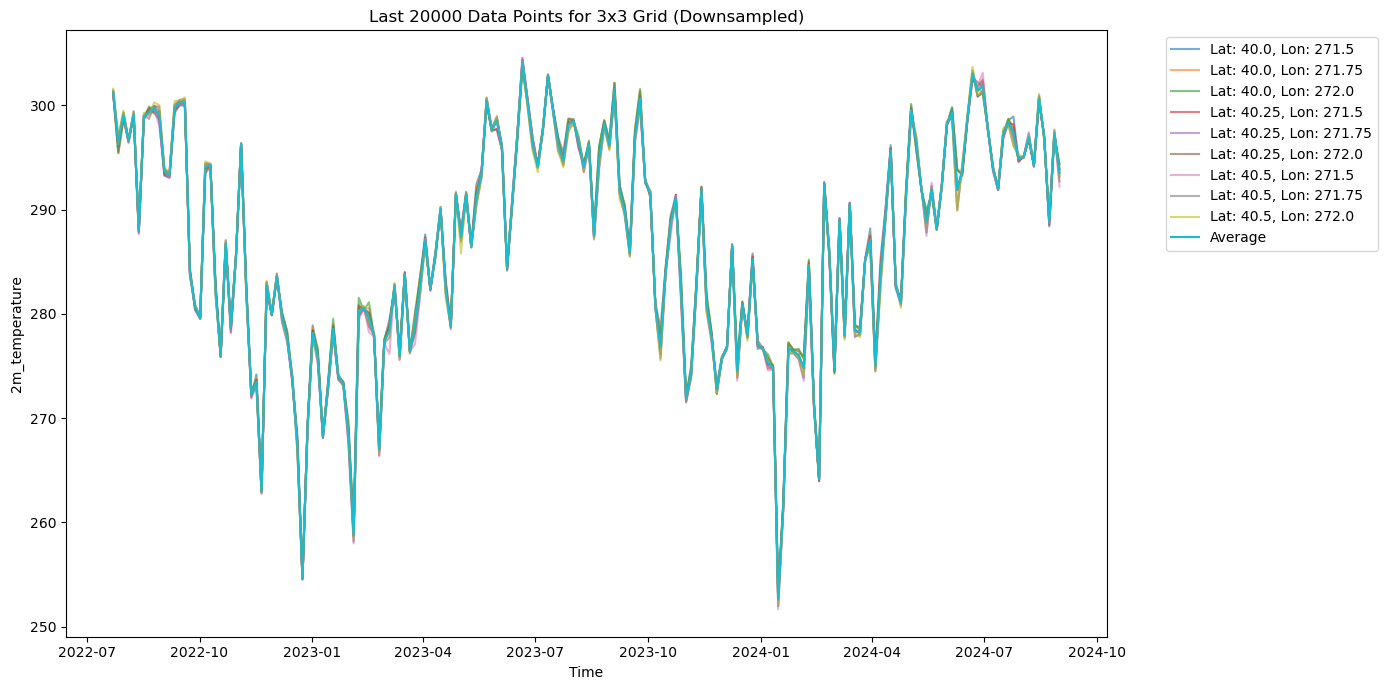

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

df_spatial = champaign_spatially_expanded_ds.isel(time=slice(-20000, None, 100)).to_dataframe().reset_index()

plt.figure(figsize=(14, 7))

# Group by lat-lon combinations and plot each time series
for (lat, lon), group in df_spatial.groupby(['latitude', 'longitude']):
    plt.plot(group['time'], group[champaign_spatially_expanded_ds.name], label=f'Lat: {lat}, Lon: {lon}', alpha=0.6)

df_spatial_mean = df_spatial.groupby('time').mean().reset_index()
plt.plot(df_spatial_mean['time'], df_spatial_mean['2m_temperature'], label=f'Average', alpha=1)

# Customize the plot
plt.title('Last 20000 Data Points for 3x3 Grid (Downsampled)')
plt.xlabel('Time')
plt.ylabel(champaign_spatially_expanded_ds.name)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend outside the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_spatial = champaign_spatially_expanded_ds.isel(time=slice(None, None, 500)).to_dataframe().reset_index()
df_spatial_mean = df_spatial.groupby('time').mean().reset_index()
df_downsampled = champaign_ds.isel(time=slice(None, None, 500)).to_dataframe().reset_index()

plt.figure(figsize=(14, 7))
plt.plot(df_spatial_mean['time'], df_spatial_mean['2m_temperature'])
plt.plot(df_downsampled['time'], df_downsampled['2m_temperature'])

plt.title('1x1 Grid and Average of 3x3 Grid (Downsampled)')
plt.xlabel('Time')
plt.ylabel(champaign_spatially_expanded_ds.name)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
import GPy
from scipy import stats

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Function to fit a Gaussian Process to the data
def fit_gp(data, coordinates):
    kernel = GPy.kern.RBF(input_dim=2, ARD=True)
    model = GPy.models.GPRegression(coordinates, data.reshape(-1, 1), kernel)
    model.optimize(messages=True)
    return model

# Function to get predictions from the GP model
def predict_gp(model, coordinates):
    mu, var = model.predict(coordinates)
    return mu.flatten(), var.flatten()

# Fit the GEV-GP to the 3x3 grid data
def fit_gp_and_gev(ds, lat, long, date, threshold):
    # Extract the data for the given day and surrounding days (e.g., date ± 10 days)
    historical_data = ds.sel(time=ds.time.dt.dayofyear.isin(range(date.dayofyear - 10, date.dayofyear + 11)))
    
    # Prepare coordinates for the 3x3 grid
    
    data_values = []
    
    # Flatten the data from the historical 3x3 grid and collect values
    for time_point in historical_data.time:
        grid = historical_data.sel(time=time_point, latitude=slice(lat - 1, lat + 1), longitude=slice(long - 1, long + 1)).values
        if not np.isnan(grid).all():
            data_values.append(grid.flatten())
    
    # Fit a GP to the data (use coordinates as input)
    data_values = np.array(data_values)
    coordinates = np.array(ds.coords)
    gp_model = fit_gp(data_values, coordinates)
    
    # Predict future temperature values using the GP model
    predicted_mean, predicted_var = predict_gp(gp_model, coordinates)
    
    # Find the extreme values for fitting the GEV distribution
    extreme_values = predicted_mean[predicted_mean > threshold]
    
    # Fit a GEV distribution to the extreme values
    shape_gev, loc_gev, scale_gev = stats.genextreme.fit(extreme_values)
    
    return shape_gev, loc_gev, scale_gev, predicted_mean, predicted_var

# Example usage:
# shape, loc, scale, predicted_mean, predicted_var = fit_gp_and_gev(ds, lat=40.11, long=-88.24, date=pd.Timestamp('1999-01-05'), threshold=30)


In [38]:
import numpy as np
import pandas as pd
import scipy.stats as stats

def grid_point_analysis_gev(ds, lat, long, date):
    today_temp = ds.sel(time=date, latitude = lat, longitude = long).values
    
    historical_data = ds.sel(time=ds.time.dt.dayofyear.isin(range(date.dayofyear - 10, date.dayofyear + 11)))
    hist_values = historical_data.values.flatten()
    hist_values = hist_values[np.isfinite(hist_values)]

    shape, loc, scale = stats.genextreme.fit(hist_values)
    
    # Classify today's temperature using the GEV distribution
    cdf_today = stats.genextreme.cdf(today_temp, shape, loc, scale)
    
    # Set thresholds for extreme classification based on the GEV CDF
    if cdf_today < 0.05:  # 5th percentile
        return 'Extremely Low'
    elif cdf_today > 0.95:  # 95th percentile
        return 'Extremely High'
    else:
        return 'Normal'

def grid_point_analysis(ds, lat, long, date):
    today_temp = ds.sel(time=date, latitude = lat, longitude = long).values

    historical_data = ds.sel(time=ds.time.dt.dayofyear.isin(range(date.dayofyear - 10, date.dayofyear + 11)))
    hist_values = historical_data.values.flatten()

    if today_temp < np.percentile(hist_values, 5):
        return 'Extremely Low'
    elif today_temp > np.percentile(hist_values, 95):
        return 'Extremely High'
    else:
        return 'Normal'


In [18]:
date = pd.Timestamp('1999-01-05')
date_str = date.strftime("%Y-%m-%d")
champaign_lat = 40.25
champaign_long = 271.75
result = grid_point_analysis(champaign_ds, champaign_lat, champaign_long, date)
result_spatial_expand = grid_point_analysis(champaign_spatially_expanded_ds, champaign_lat, champaign_long, date)

print(f"Classification of temperature on {date_str} is: ", result)
print(f"Classification of temperature on {date_str} spacially expanded is: ", result_spatial_expand)

Classification of temperature on 1999-01-05 is:  Extremely Low
Classification of temperature on 1999-01-05 spacially expanded is:  Normal


In [ ]:
from flox.xarray import xarray_reduce
import numpy as np

def grid_point_analysis_time_expanded(ds, lat, long, date):
    ds_ten = ds.sel(time=ds.time.dt.dayofyear.isin(range(date.dayofyear - 10, date.dayofyear + 11)))
    ds_week = ds.sel(time=ds.time.dt.isocalendar().week == date.isocalendar().week)
    ds_month = ds.sel(time=ds.time.dt.month == date.month)

    ten_avg = xarray_reduce(
        ds_ten,
        ds_ten.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    weekly_avg = xarray_reduce(
        ds_week,
        ds_week.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    monthly_avg = xarray_reduce(
        ds_month,
        ds_month.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    percentiles_ten = np.percentile(ten_avg, [5, 50, 95])
    percentiles_week = np.percentile(weekly_avg, [5, 50, 95])
    percentiles_month = np.percentile(monthly_avg, [5, 50, 95])

    # Determine classification for each time frame
    def classify_temp(today_temp, percentiles):
        if today_temp < percentiles[0]:
            return 'Extreme Low'
        elif today_temp > percentiles[2]:
            return 'Extreme High'
        else:
            return 'Normal'

    today_temp = ds.sel(time=date, latitude = lat, longitude = long).values
    
    classification_ten = classify_temp(today_temp, percentiles_ten)
    classification_week = classify_temp(today_temp, percentiles_week)
    classification_month = classify_temp(today_temp, percentiles_month)

    return {
        'today_temp': today_temp,
        'percentiles_ten': percentiles_ten,
        'classification_ten': classification_ten,
        'percentiles_week': percentiles_week,
        'classification_week': classification_week,
        'percentiles_month': percentiles_month,
        'classification_month': classification_month,
    }


def grid_point_analysis_time_expanded_gev(ds, lat, long, date):
    ds_ten = ds.sel(time=ds.time.dt.dayofyear.isin(range(date.dayofyear - 10, date.dayofyear + 11)))
    ds_week = ds.sel(time=ds.time.dt.isocalendar().week == date.isocalendar().week)
    ds_month = ds.sel(time=ds.time.dt.month == date.month)

    ten_avg = xarray_reduce(
        ds_ten,
        ds_ten.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    weekly_avg = xarray_reduce(
        ds_week,
        ds_week.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    monthly_avg = xarray_reduce(
        ds_month,
        ds_month.time.dt.year,
        func='mean',
        dim=["time"],
        engine='flox'
    ).values.flatten()

    # Determine classification for each time frame
    def classify_temp(today_temp, hist_values):
        shape, loc, scale = stats.genextreme.fit(hist_values)
        cdf_today = stats.genextreme.cdf(today_temp, shape, loc, scale)
        # Set thresholds for extreme classification based on the GEV CDF
        if cdf_today < 0.05:  # 5th percentile
            return 'Extremely Low'
        elif cdf_today > 0.95:  # 95th percentile
            return 'Extremely High'
        else:
            return 'Normal'

    today_temp = ds.sel(time=date, latitude = lat, longitude = long).values
    
    classification_ten = classify_temp(today_temp, ten_avg)
    classification_week = classify_temp(today_temp, weekly_avg)
    classification_month = classify_temp(today_temp, monthly_avg)

    return {
        'today_temp': today_temp,
        'classification_ten': classification_ten,
        'classification_week': classification_week,
        'classification_month': classification_month,
    }

In [ ]:
date = pd.Timestamp('1999-01-05')
date_str = date.strftime("%Y-%m-%d")
champaign_lat = 40.25
champaign_long = 271.75
result_time = grid_point_analysis_time_expanded(champaign_ds, champaign_lat, champaign_long, date)
result_time_spatial_expand = grid_point_analysis_time_expanded(champaign_spatially_expanded_ds, champaign_lat, champaign_long, date)

print(f'Classification of temperature on {date_str} time expanded is: ')
print(f'\t{result_time["classification_ten"]} in +- 10 day timeframe')
print(f'\t{result_time["classification_ten"]} in Week timeframe')
print(f'\t{result_time["classification_ten"]} in Month timeframe')

print(f'Classification of temperature on {date_str} time and spacially expanded is: ')
print(f'\t{result_time["classification_ten"]} in +- 10 day timeframe')
print(f'\t{result_time["classification_ten"]} in Week timeframe')
print(f'\t{result_time["classification_ten"]} in Month timeframe')

In [ ]:
num_events = 0
times = []
lats = []
longs = []
temps = []
classifications = []
for timestamp in champaign_ds.time.values[::-1]:
    classification = grid_point_analysis_gev(champaign_ds, champaign_ds.latitude.values[0], champaign_ds.longitude.values[0], pd.Timestamp(timestamp))
    if classification != "Normal":
        num_events += 1
        times.append(timestamp)
        lats.append(champaign_ds.latitude.values[0])
        longs.append(champaign_ds.longitude.values[0])
        temps.append(champaign_ds.sel(time = timestamp).values[0][0])
        classifications.append(classification)
        if num_events == 50:
            break

df_past_50_extremes = pd.DataFrame({
    "Time": times,
    "Latitude": lats,
    "Longitude": longs,
    "Temperature": temps,
    "Classification": classifications
})

In [32]:
date = pd.Timestamp('1999-01-05')

champaign_ds.sel(time = date).values[0][0]

251.70203